# Function 1 - Identifying Radiation Sources
-It corresponds to trying to find the source of radiation in some square area. You can only detect the radiation once you are very close to it, meaning most of the readings will be zero.


In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
%matplotlib inline

f1_inp = np.load("./../function_1/initial_inputs.npy")
f1_out = np.load("./../function_1/initial_outputs.npy")#comeback
f1_out
#location

file2_inp = np.load("./../../initial_data2/function_1/initial_inputs.npy")
file2_out = np.load("./../../initial_data2/function_1/initial_outputs.npy")

f1_inp = np.concatenate((f1_inp, file2_inp))
f1_out = np.concatenate((f1_out, file2_out))


q1_inp = [0.193873, 0.348642]
q1_out = [1.9483690822999093e-40]


q2_inp = [0.000852, 0.019615]
q2_out = [2.9831349749726576e-236]

q3_inp = [0.826252, 0.8145  ]
q3_out = [-2.8266466860707447e-53]


q4_inp = [0.825044, 0.83331]
q4_out = [4.399197870898054e-59]


q5_inp = [0.245924, 0.469973]
q5_out = [-2.4018319839855543e-24]


q6_inp = [0.642817, 0.950723]
q6_out = [8.56175686498828e-73]


q7_inp = [0.604571, 0.568934]
q7_out = [-0.0011316084087011602]


q8_inp = [0.483675, 0.319433]
q8_out = [5.598113021888589e-11]


q8_inp = [0.483675, 0.319433]
q8_out = [5.598113021888589e-11]


q9_inp = [0.624484, 0.639821]
q9_out = [1.4113100297315333]  

q10_inp = [0.637917, 0.641067]
q10_out = [1.1031058574767865]


q11_inp = [0.621091, 0.641312]
q11_out = [1.1755023580959656]

q12_inp = [0.622000, 0.639486]
q12_out = [1.3489265462951858]

q13_inp = [0.627484, 0.639921]
q13_out = [1.4561642447090]

f1_inp = np.vstack((f1_inp, q1_inp, q2_inp, q3_inp, q4_inp, q5_inp,q6_inp,q7_inp,q8_inp,q9_inp,q10_inp,q11_inp,q12_inp,q13_inp))
f1_out = np.append(f1_out, [q1_out, q2_out,q3_out, q4_out, q5_out,q6_out,q7_out,q8_out,q9_out,q10_out,q11_out,q12_out,q13_out])
f1_inp, f1_out
max(f1_out), np.mean(f1_out)

len(f1_inp), len(f1_out)

max(f1_out)      

np.float64(1.456164244709)

In [2]:
idx = np.argmax(f1_out)

value_max_out = f1_out[idx]
vale_max_inp = f1_inp[idx]
value_max_out, vale_max_inp

(np.float64(1.456164244709), array([0.627484, 0.639921]))

In [6]:
# Notes no transformation happend to the first one 

In [3]:
x_final = f1_inp
y_final = f1_out


In [25]:
import numpy as np

# Get indices of top 3 outputs (higher = better)
top_indices = np.argsort(y_final)[-3:][::-1]

# Get the top 3 output values
top_outputs = y_final[top_indices]

# Get corresponding inputs
top_inputs = x_final[top_indices]
top_indices,top_inputs, top_outputs

(array([38, 40, 39]),
 array([[0.624484, 0.639821],
        [0.621091, 0.641312],
        [0.637917, 0.641067]]),
 array([1.41131003, 1.17550236, 1.10310586]))

# Exploratory Data Analysis (EDA) for Bayesian Optimization 

## **Objective**
The goal of the Exploratory Data Analysis (EDA) is to investigate the characteristics of the input-output relationships, data quality, and patterns that influence the performance of Bayesian Optimization. This analysis will help guide the selection of kernel parameters, acquisition functions, and input transformations to optimize model performance and robustness.


1. **Data Quality**  
   - Identify outliers via z-scores or IQR (ensures kernel parameters aren’t distorted by extreme values, example an outlier can create unrealistic length scales or amplitude of kernel parameters). Consider removing or transforming them.
   - Check for missing/null values and decide on imputation or removal (helps avoid skewing the GP’s fit). Remove duplicates if there is any  (prevents overemphasis on certain points).  


2. **Data Distribution**  
   - Plot histograms to spot skewness (so we can apply tansfromation of input and output), to address heteroscedascity.  
   - Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000), larger ranges dominate distance calculations, distorting kernel behavior).
    - Check, variance, skewnes which can be needed in further steps

3. **Input-Output Relationships**  
   - Use correlation matrices to find strong or weak drivers of the target (remove features that are not relevant and add noise to the data).  
   - Visualize scatter/surface plots (reveals potential nonlinearity or interactions for better GP modeling).
   

6. **Noise and Uncertainty**  
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).  
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - Consider removing  as the step above if it removes the noise 
     - If skewness is low but variance is high in RESIDUALS, focus on adding a noise term to the kernel, reults from step 2
7. **Feature Engineering**  
   - Apply dimensionality reduction (e.g., PCA) if many correlated features (simplifies model, reduces noise).  
   - Assess feature importance (e.g., SHAP) to prioritize critical inputs (focuses GP where it matters).
   

4. **Kernel Suitability Exploration,  Set data-driven Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput
   - Lengthscle check variance on input
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
   - Select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Match kernel amplitude to output variance (captures overall scale of the data).  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 

8. **Acquisition Function Behavior**  
   - Monitor exploration-exploitation trade-offs (e.g., EI, PI, UCB) to ensure effective sampling (speeds convergence).  
   - Adjust parameters like \(\beta\) or \(\xi\) to fine-tune that balance (enhances optimization efficiency).


9. **Iterative Refinement**  
   - Revisit EDA after initial Bayesian runs (refine kernel hyperparameters, acquisition settings).  
   - Visualize updated surfaces and residuals (validates improvements and ensures robust GP performance).


In [16]:
from scipy.stats import skew 

pd_inp = pd.DataFrame(f1_inp)
pd_out = pd.DataFrame(f1_out, columns=["Output"])


pd_inp.describe()
pd_out.describe()

pd_inp.isnull().sum()  # No null on input 0 , 1 are the columns 
pd_out.isnull().sum()  # No null on output
sum(pd_inp.duplicated())   # 0 duplicates
sum(pd_out.duplicated())   # 0 duplicates





0

<Axes: >

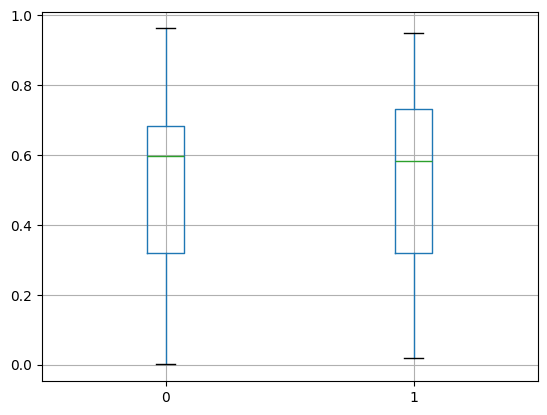

In [17]:

pd_inp.boxplot() # No outliers second feature more spread, need to standarise features, so it fits kernel, if Matern, RBA


<Axes: >

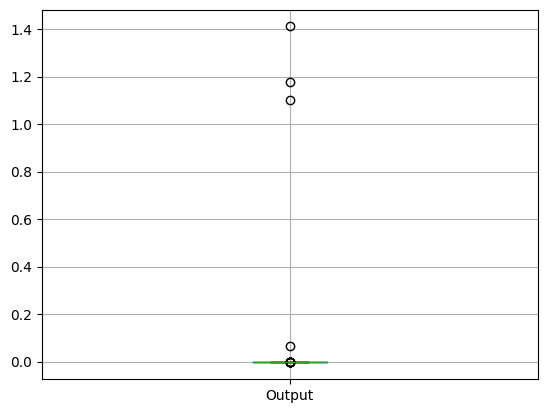

In [18]:
pd_out.boxplot() # No outliers 

In [19]:
min(f1_out)

np.float64(-0.0036060626443634764)

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object),
 array([[<Axes: title={'center': 'Output'}>]], dtype=object))

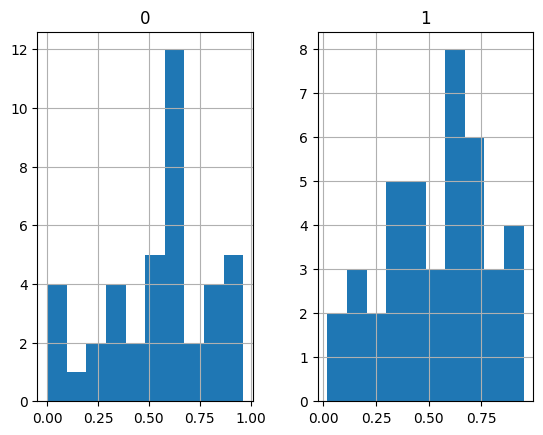

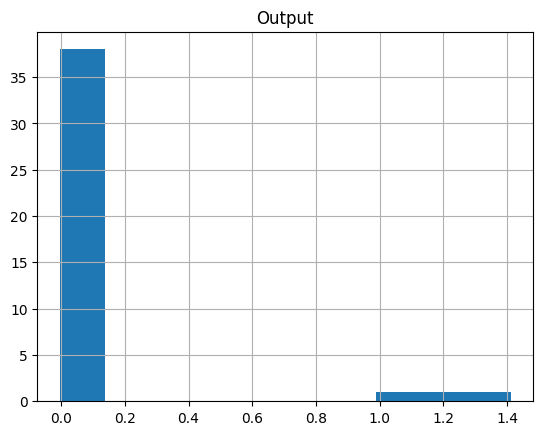

In [20]:
pd_inp.hist(), pd_out.hist()

In [21]:
skew(f1_inp),skew(f1_out)

(array([-0.3884251 , -0.29696811]), np.float64(3.344949009575114))

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object),
 array([[<Axes: title={'center': 'Output'}>]], dtype=object))

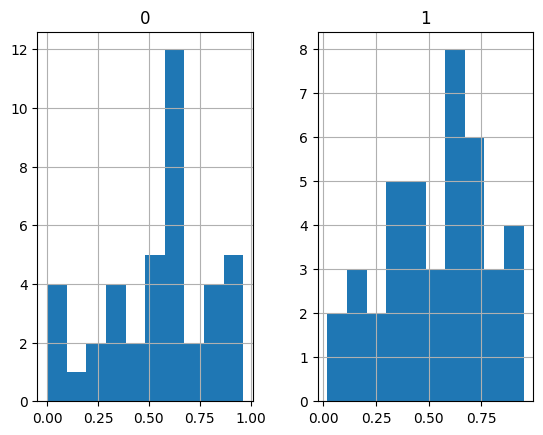

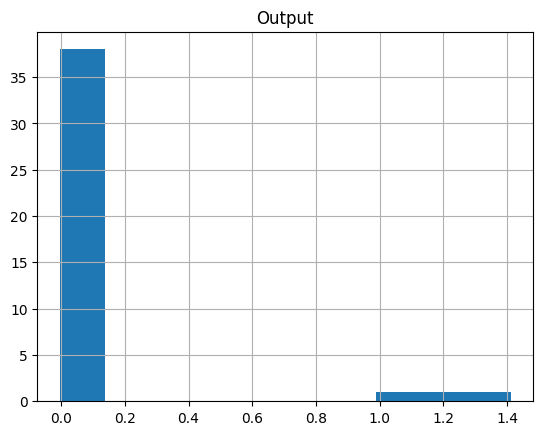

In [22]:
pd_inp.hist(), pd_out.hist()

# Input/Output Relationship Analysis 

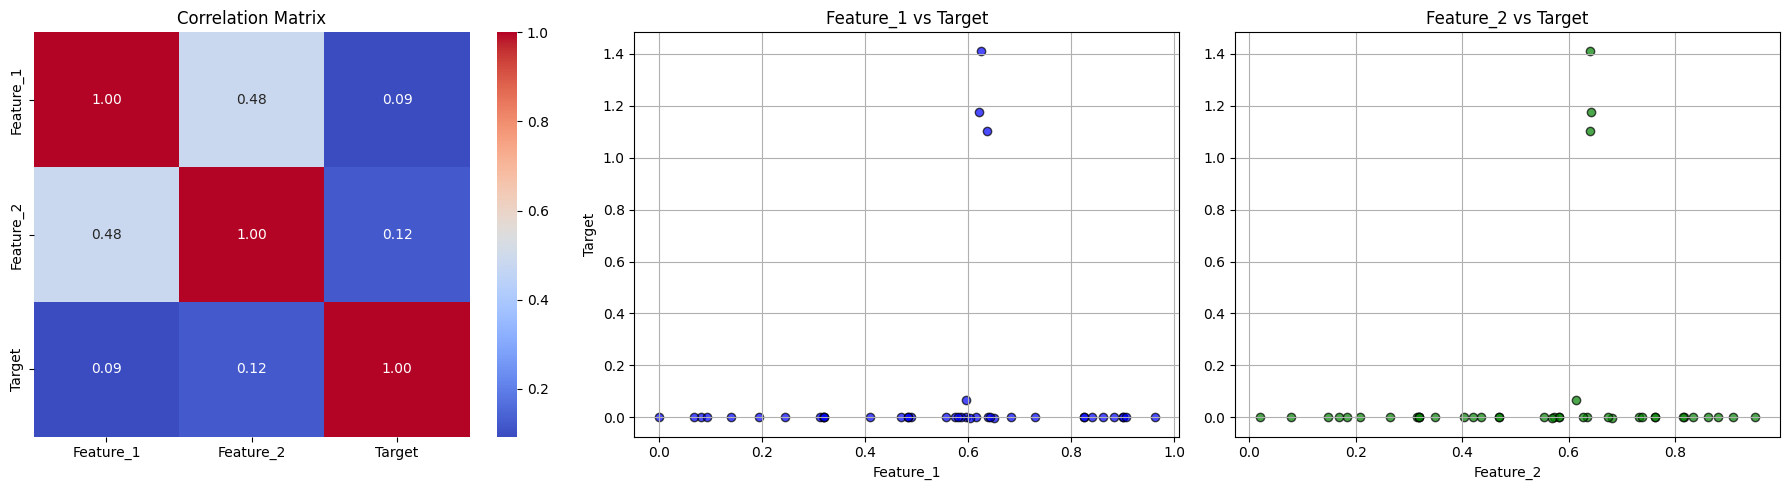

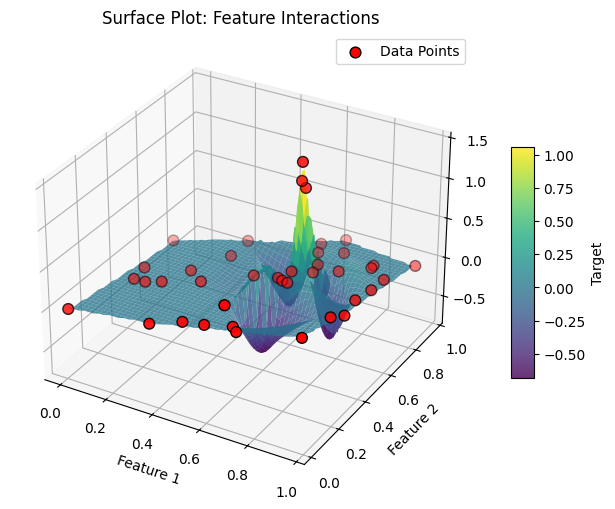

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

# Ensure f1_out is 1D
f1_out = f1_out.ravel()

# Create a figure for the inline plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# **1. Correlation Matrix**
# Convert f1_inp and f1_out to a single NumPy array for correlation
data = np.hstack((f1_inp, f1_out.reshape(-1, 1)))

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(data.T)

# Plot correlation heatmap
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f",
    xticklabels=[f"Feature_{i+1}" for i in range(f1_inp.shape[1])] + ["Target"],
    yticklabels=[f"Feature_{i+1}" for i in range(f1_inp.shape[1])] + ["Target"],
    ax=axes[0]
)
axes[0].set_title("Correlation Matrix")

# **2. Scatter Plot: Feature 1 vs Target**
axes[1].scatter(f1_inp[:, 0], f1_out, color="blue", alpha=0.7, edgecolor="k")
axes[1].set_xlabel("Feature_1")
axes[1].set_ylabel("Target")
axes[1].set_title("Feature_1 vs Target")
axes[1].grid(True)

# **3. Scatter Plot: Feature 2 vs Target (if exists)**
if f1_inp.shape[1] > 1:
    axes[2].scatter(f1_inp[:, 1], f1_out, color="green", alpha=0.7, edgecolor="k")
    axes[2].set_xlabel("Feature_2")
#     axes[2].set_ylabel("Target")
    axes[2].set_title("Feature_2 vs Target")
    axes[2].grid(True)
else:
    axes[2].axis("off")
    axes[2].set_title("Feature_2 vs Target (Not Available)")

plt.tight_layout()
plt.show()





# ---------------**3D Surface Plot (Separate Block for Feature Interaction)**
#if f1_inp.shape[1] == 2:  # Ensure input is 2D
x, y = f1_inp[:, 0], f1_inp[:, 1]
z = f1_out

# Create grid points for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

# Interpolate the Z values for the grid
grid_z = griddata(
    (x, y), z, 
    (grid_x, grid_y), 
    method="cubic"
)

  # This visual can be good for function 1 to identify the two local minimas   
#     # Handle potential issues with NaN values in grid_z
#     if np.isnan(grid_z).any():
#         grid_z = np.nan_to_num(grid_z)  # Replace NaNs with zeros or interpolated values

# Plotting the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    grid_x, grid_y, grid_z, 
    cmap="viridis", 
    edgecolor="none", 
    alpha=0.8
)
# Scatter points (data points)
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
ax.legend(loc="best")  # Add legend for clarity

cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Target")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
#     ax.set_zlabel("Target")
plt.title("Surface Plot: Feature Interactions")
plt.show()
# else:
#     print("Surface plot requires exactly 2 features in the input data.")
    
    
# The red on the 3d surface plot its just to make the plot easier to see


### Inp/out relationship conclusions 

- We can see that features are very similarily correlated with target variables, we can try to remove one of them. Idea: Remove the outlier to better see a relationship between these datapoints 
- Outlier dedected on the output


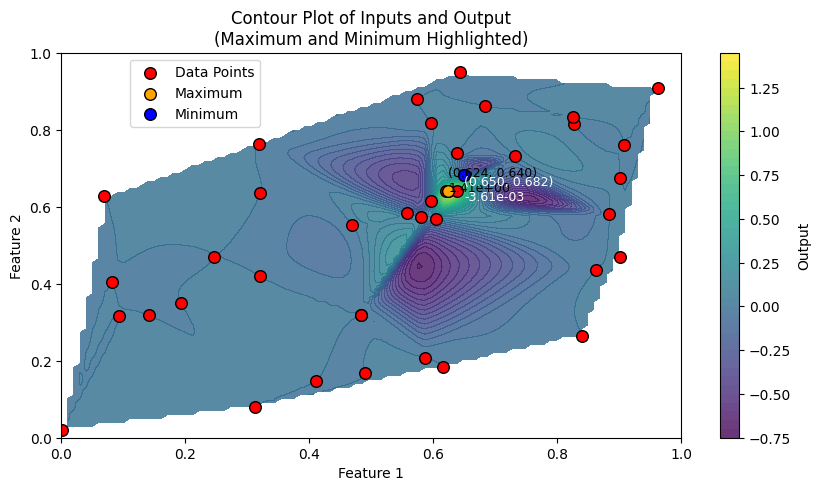

Max: 1.41e+00 at (0.6245, 0.6398)
Min: -3.61e-03 at (0.6501, 0.6815)


In [25]:

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Identify max/min points
max_idx, min_idx = np.argmax(z), np.argmin(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
plt.scatter(x, y, color='red', edgecolor='black', s=70, label="Data Points")
plt.scatter([max_x], [max_y], color='orange', edgecolor='black', s=70, label="Maximum")
plt.text(max_x, max_y, f"({max_x:.3f}, {max_y:.3f})\n{max_z:.2e}", fontsize=9, color='black')
plt.scatter([min_x], [min_y], color='blue', edgecolor='black', s=70, label="Minimum")
plt.text(min_x, min_y, f"({min_x:.3f}, {min_y:.3f})\n{min_z:.2e}", fontsize=9, color='white',
         ha='left', va='top')
plt.xlabel("Feature 1"), plt.ylabel("Feature 2")
plt.title("Contour Plot of Inputs and Output\n(Maximum and Minimum Highlighted)")
plt.legend()
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1.0))

plt.show()

print(f"Max: {max_z:.2e} at ({max_x:.4f}, {max_y:.4f})")
print(f"Min: {min_z:.2e} at ({min_x:.4f}, {min_y:.4f})")

## Analysing noise and uncertianty 
     
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2 
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2
    - Test after you have built the surrogate model, if there are future that just add noise and affect predictions 
    
- Aim: Follow a data-driven strategy, based on the parameters of the data, to set the inital parameter of the kernel

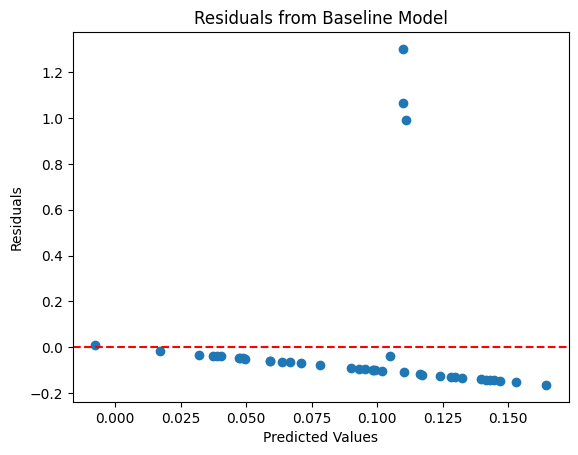

Residual Variance: 0.105
Residual Mean: 0.000


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Example Data (replace with your data)
x = f1_inp
z = f1_out  # Observed target

# Fit a baseline model (Linear Regression)
model = LinearRegression()
model.fit(x, z)
z_pred = model.predict(x)  # Predictions from the baseline model

# Residuals
residuals = z - z_pred

# Plot Residuals
plt.scatter(z_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals from Baseline Model")
plt.show()

# Print Residual Statistics
print(f"Residual Variance: {np.var(residuals, ddof=1):.3f}")
print(f"Residual Mean: {np.mean(residuals):.3f}")


In [12]:
# Signal Variance (Variance of Predictions)
signal_variance = np.var(z_pred, ddof=1)

# Residual Variance (Variance of Noise)
residual_variance = np.var(residuals, ddof=1)
residual_skewness = skew(residuals)
# Signal-to-Noise Ratio (SNR)
snr = signal_variance / residual_variance

# Display Metrics
print(f"Signal Variance: {signal_variance:.8f}")
print(f"Residual Variance (Noise): {residual_variance:.8f}")
print(f"Residual Skewnes : {residual_skewness:.8f}")
print(f"Signal-to-Noise Ratio (SNR): {snr:.8f}")


Signal Variance: 0.00174652
Residual Variance (Noise): 0.10454353
Residual Skewnes : 3.25421956
Signal-to-Noise Ratio (SNR): 0.01670613


4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput will match kernel amplitude to output variance (captures overall scale of the data). 
   - Lengthscle check variance on input, will select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 


In [13]:
output_variance = np.var(f1_out, ddof=1)
amplitude_init = np.sqrt(output_variance)
amplitude_init

input_variance = np.var(f1_inp, axis=0, ddof=1)
length_scale_init = np.sqrt(input_variance)
length_scale_init

# Bounds will always be the bounds of the input variable, IMPORTANT TO CHECK FOR OUTLIERS
min_bounds = np.min(f1_inp, axis=0)
max_bounds = np.max(f1_inp, axis=0)

# Extend bounds slightly (10% of range)
range_extension = 0.1 * (max_bounds - min_bounds)
extended_min_bounds = min_bounds - range_extension
extended_max_bounds = max_bounds + range_extension
amplitude_init,length_scale_init,  extended_min_bounds, extended_max_bounds

(np.float64(0.32602153673850465),
 array([0.25964548, 0.24538042]),
 array([-0.09529029, -0.0734958 ]),
 array([1.05841724, 1.0438338 ]))

- Start with the above Amplitude but let the optimizer refine it during training
- Start with the above Lenfthscale but let the optimizer refine it during training

### --- Input/Output tranformation skiped in the first round of quering, as I did not find a way of scaling the numbers, and get a better LML from it. 

# ***************************** Output Transformation ******************************* 
- I will use Yeo-Johnson method to hanlde the heteroscedastic nature of the data, tranform outputs, and fic asymmetric skewness. 
- Reason I am using Yeo-Johnson is because we have positive and negative values as ouput 



(array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
         3.34177101e-124, -3.60606264e-003, -2.15924904e-054,
        -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
         6.22985647e-048, -3.23831206e-070, -2.66554974e-065,
        -6.53456227e-084,  1.33208482e-048,  2.94212475e-055,
         8.33516100e-040, -5.03981978e-008, -2.01007653e-009,
         6.59147585e-002,  5.59549084e-011,  4.50954445e-133,
        -4.05280070e-015, -7.40958578e-118,  8.49132032e-027,
        -8.80550875e-064, -9.89621108e-052, -2.68384158e-067,
         1.19343278e-067,  6.90381175e-005,  4.65270195e-006,
         1.94836908e-040,  2.98313497e-236, -2.82664669e-053,
         4.39919787e-059, -2.40183198e-024,  8.56175686e-073,
        -1.13160841e-003,  5.59811302e-011,  1.41131003e+000,
         1.10310586e+000,  1.17550236e+000]),
 array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
         3.34177101e-124, -3.60606264e-003, -2.15924904e-054,
        -2.08909327e-091

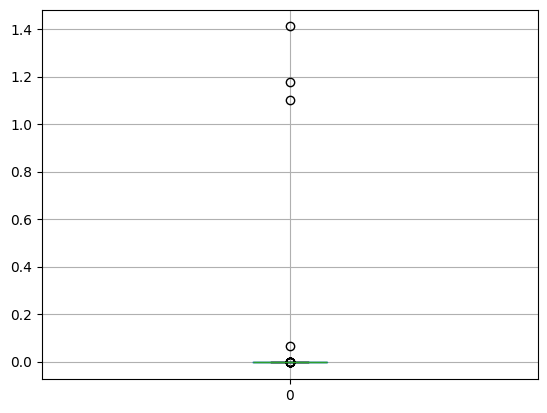

In [14]:
# 1️⃣ Clip the outliers first
max_threshold = np.percentile(f1_out, 95)  # Limit at 95th percentile
f1_out_clipped = np.clip(f1_out, -max_threshold, max_threshold)


df1 = pd.DataFrame(f1_out)
df2 = pd.DataFrame(f1_out_clipped)
df1.boxplot()


f1_out, f1_out_clipped

<Axes: >

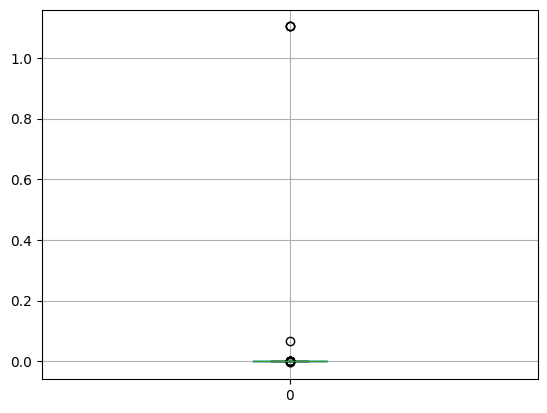

In [15]:
df2.boxplot()

Chosen scale factor = 5.821739917088615e+47
Recovery Error = 6.217248937900877e-15
---------------------------
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048 -3.23831206e-070 -2.66554974e-065
 -6.53456227e-084  1.33208482e-048  2.94212475e-055  8.33516100e-040
 -5.03981978e-008 -2.01007653e-009  6.59147585e-002  5.59549084e-011
  4.50954445e-133 -4.05280070e-015 -7.40958578e-118  8.49132032e-027
 -8.80550875e-064 -9.89621108e-052 -2.68384158e-067  1.19343278e-067
  6.90381175e-005  4.65270195e-006  1.94836908e-040  2.98313497e-236
 -2.82664669e-053  4.39919787e-059 -2.40183198e-024  8.56175686e-073
 -1.13160841e-003  5.59811302e-011  1.10310586e+000  1.10310586e+000
  1.10310586e+000]
[ 7.70028172e-032  4.78994348e+000  7.58775159e+001  1.94549217e-076
 -1.05051107e+002 -1.25705863e-006 -1.21621577e-043  1.95030361e+001
  2.09976838e-033  2.00000000e+000 -1.8852

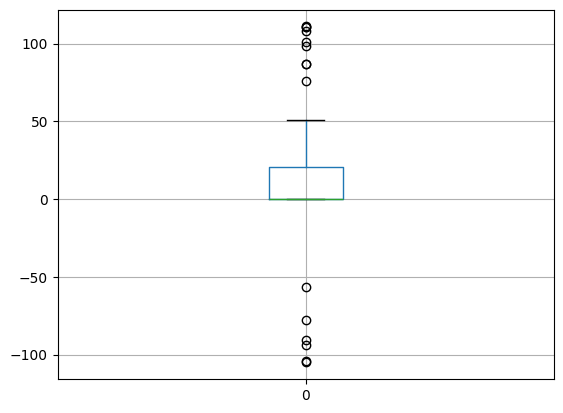

In [29]:
# Step 1: Define epsilon
epsilon = 0

# Step 2: Filter values based on epsilon
filtered_values = f1_out[np.abs(f1_out) > epsilon]

# Step 3: Define functions for scaling (arcsinh transformation)
def determine_scale(y, percentile=99, target_asinh_value=5.0):
    """
    Determines a scale factor so that the 'percentile' of |y|
    ends up around arcsinh = ±target_asinh_value.
    """
    abs_y = np.abs(y[np.abs(y) > epsilon])  # Filter using epsilon
    if len(abs_y) == 0:
        return 1.0  # Fallback in case all values are filtered out
    
    # Get the chosen percentile of the absolute values
    val = np.percentile(abs_y, percentile)
    if val == 0:
        return 1.0  # Fallback if percentile value is 0
    
    # Determine scale
    desired = np.sinh(target_asinh_value)
    scale = desired / val
    return scale

def forward_transform(y, scale):
    """
    Forward transform for GP:
      arcsinh(scale * y)
    """
    return np.arcsinh(scale * y)

def inverse_transform(y_trans, scale):
    """
    Inverse transform:
      sinh(y_trans) / scale
    """
    return np.sinh(y_trans) / scale

# Step 4: Determine scale factor
# Below what the determine_scale is doign it is compresing further the values that fall outside the 50% percentile
# target_asing_value it is how aggressive the compresion it will be. 
# Higher percentile it means less data extremes to be compressed, also means perserves relationship better when outliers exists
# Higher target_asinh_value it means more aggressive compression over the selected region 
scale_factor = determine_scale(filtered_values, percentile=50, target_asinh_value=2)
print("Chosen scale factor =", scale_factor)

# Step 5: Transform the data
f1_out_transformed = forward_transform(filtered_values, scale=scale_factor)


# Step 6: Validate inverse transformation
f1_out_recovered = inverse_transform(f1_out_transformed, scale=scale_factor)
recovery_error = np.max(np.abs(filtered_values - f1_out_recovered))
print("Recovery Error =", recovery_error)
print("---------------------------")
print(f1_out_clipped)
print(f1_out_transformed)
print(f1_out_recovered)
print("Mean Tranformed", np.mean(f1_out_transformed))

df3 = pd.DataFrame(f1_out_transformed)
df3.boxplot()
print("max value:",max(f1_out_transformed))

##### *** Normalization below to be considered as it is resulting in memory loss when quartile is high, and probarly in loss of relationship when quartile is low  ***

[-0.12581185 -0.01109111  1.27674859 -0.12581185 -2.05688765 -0.12581196
 -0.12581185  0.25545579 -0.12581185 -0.06195233 -0.12581185 -0.12581185
 -0.12581185 -0.0895794  -0.12581184  0.27701933 -1.85438137 -1.79601483
  1.8579051   1.47951    -0.12581185 -1.55843366 -0.12581185  0.81963956
 -0.12581185 -0.12586066 -0.12581185 -0.12581185  1.73360136  1.68473808
  0.25068757 -0.12581185 -0.12581324 -0.12581185 -1.17352832 -0.12581185
 -2.03589137  1.47951849  1.9134116 ]
<class 'numpy.ndarray'> (39,)


(0   -1.138690e-17
 dtype: float64,
 0    1.013072
 dtype: float64)

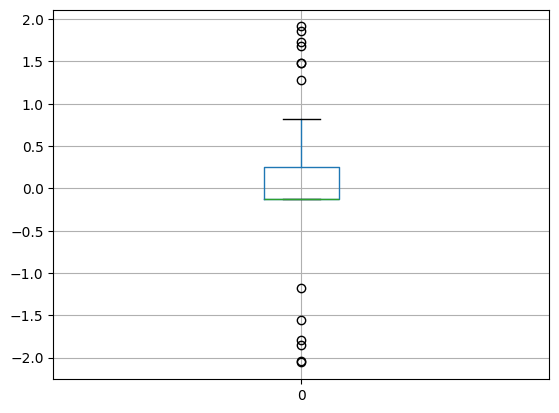

In [45]:
# Further normalisation after I noticed that further normalisation imporves the LML 

y_mean = np.mean(f1_out_transformed)
y_std = np.std(f1_out_transformed)

# === Step 2: Normalize the Output Manually ===
y_normalized = (f1_out_transformed - y_mean) / y_std
print(y_normalized)
print(type(y_normalized), y_normalized.shape)
norm_pd = pd.DataFrame(y_normalized)
norm_pd.boxplot()
norm_pd.mean(), norm_pd.std()

### Conclusions  about output normalisation
- I am observing a wired behaivour which I suspect is because of the outliers 
- 1) When I Soft Clip + arctangent (with higher quartile) + Further normalisation: I get a result of identical values. I think this is happening because of many extreme values on the dataset, and since the arcatanget is covering or compressing just a small porportion of the dataset, it is resulting in these inner extreme values not being compressed Leading to identical values when final normalization is done
- 2) When I perform SoftClip + arctangent(lower quartile 10%) + Further normalization: I get unique values as final result. This confirm the above doubt of the presence of the extreme values or high variability of the data, which I raise above. 

    - Final thoughts:
        - I am considering to not apply a lower quartile of the arcatanget tranformation as I am afraid this it will mean applyinh too much compression on the majoirty of the data, exmp: if percentile=10%, means that 90% of the data it will be compressed, loosing too much the variability and the true relationship of the data. 
        - Higher quartile brings the problem of the last Normalizaiton, so I am considering to just remove the last step. 
        - SUM UP: Higher Quartile on the Arctangent + Remove the last step

------------------------Comparing the distribution of the ouputs on diffrent parts of the proccess--------------


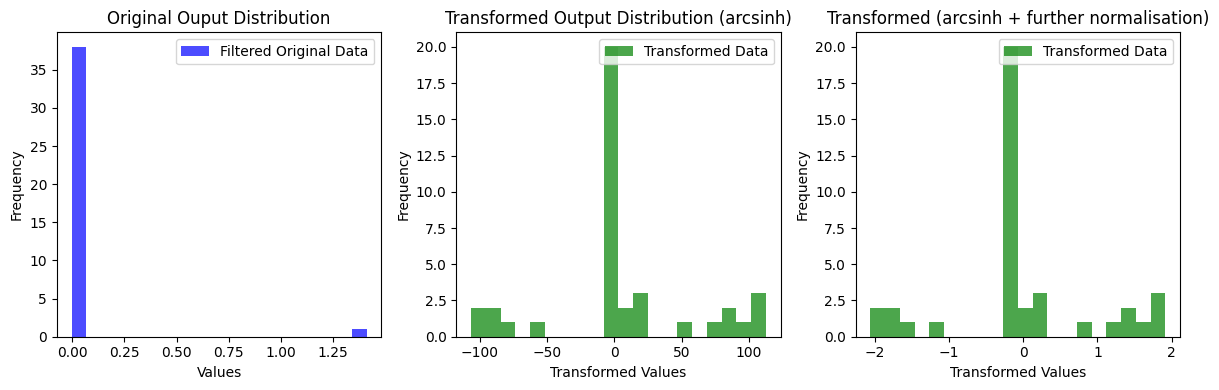

In [46]:
print("------------------------Comparing the distribution of the ouputs on diffrent parts of the proccess--------------")
# Step 7: Plot original and transformed data
plt.figure(figsize=(12, 4))

# Original data (filtered)
plt.subplot(1, 3, 1)
plt.hist(pd_out, bins=20, alpha=0.7, color='blue', label="Filtered Original Data")
plt.title("Original Ouput Distribution")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.legend()

# Transformed data
plt.subplot(1, 3, 2)
plt.hist(f1_out_transformed, bins=20, alpha=0.7, color='green', label="Transformed Data")
plt.title("Transformed Output Distribution (arcsinh)")
plt.xlabel("Transformed Values")
plt.ylabel("Frequency")
plt.legend()

# Transformed data
plt.subplot(1, 3, 3)
plt.hist(y_normalized, bins=20, alpha=0.7, color='green', label="Transformed Data")
plt.title("Transformed (arcsinh + further normalisation)")
plt.xlabel("Transformed Values")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

- Scale Factor: Compresses outliers by dividing the data, bringing extreme values closer to the main range.
- Target asinh Value: Defines the transformed range, helping to differentiate values by spreading smaller ones further apart.

##### Deciding if I should remove the outlier on the outputs based on Domain Knowledge about the ranges that the radiation can take. 
- I will reduce the outliers since it remains too far from the rest, it will be  ratio of the distance of the smallest values with second smallest 
- This is the only input output tranformation I will make


# ************************** Input Transformation************************** 
- #### First I will use the Kumaraswammy Cumulative Distribution Function to addres:

- Non Stationary nature of the function, the way way the patter in the data changes over the unput space, example, rapidly grows in some regions and slower in some other regions 
- I will use the CDF and finds its best parameters by minimising NLML(Negative Log Marginal Likelyhood)

<!-- ## First tranformation will be to introduce the inverse law. 
## I WILL SKIP IT ON Q8 -->

In [20]:
# best_idx = np.argmax(f1_out)
# print("best idx", best_idx)
# source = f1_inp[best_idx]  # This is our source (optimal input)
# print("Source (optimal input):", source)

# # 2. Compute the difference vectors for each input from the source
# diff = f1_inp - source

# # 3. Calculate Euclidean distances from the source for each input
# epsilon = 1e-8  # small value to prevent division by zero
# distances = np.sqrt(np.sum(diff ** 2, axis=1))
# print("Distances from source:", distances)

# # 4. Compute the unit vectors (direction from the source)
# # Adding epsilon in the denominator to avoid division by zero
# unit_vectors = diff / (distances[:, None] + epsilon)

# # 5. Calculate the inverse-square magnitude
# inverse_magnitude = 1.0 / (distances ** 2 + epsilon)
# inverse_magnitude = inverse_magnitude.reshape(-1, 1)  # reshape to (n_samples, 1)

# # 6. Create the new 2D transformed input by scaling the unit vectors
# inverse_law_transformed = unit_vectors * inverse_magnitude

# print("Inverse-square law transformed (new 2D input):")
# print(inverse_law_transformed)

In [21]:
# import pandas as pd

# # Create a DataFrame with two column names since transformed_input_feature has shape (n, 2)
# df_transformed = pd.DataFrame(transformed_input_feature, columns=["Feature1", "Feature2"])

# # Plot histogram using df.hist()
# df_transformed.hist()


In [47]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler

# Normalize the input
scaler = MinMaxScaler()
f1_inp_normalized = scaler.fit_transform(f1_inp)
np.std(f1_inp_normalized), np.std(f1_inp)
# skew(f1_inp_normalized), skew(f1_inp)
f1_inp_normalized
# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b


In [23]:
import numpy as np
from scipy.stats import skew
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm

# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b

# Objective function
def evaluate(individual):
    a, b = individual
    X_warped = kumaraswamy_warp(f1_inp_normalized, a, b)
    variance = np.var(X_warped)
    skewness = np.mean(np.abs(skew(X_warped, axis=0)))
    return (variance + skewness,)

# Setup DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_a", random.uniform, 0.01, 2.0)
toolbox.register("attr_b", random.uniform, 0.01, 2.0)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_a, toolbox.attr_b), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
population = toolbox.population(n=50)

# Define number of generations
NGEN = 30
CX_PROB = 0.5
MUT_PROB = 0.2

# Statistics to keep track of progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Run Genetic Algorithm with progress bar
for gen in tqdm(range(NGEN), desc="Genetic Algorithm Generations"):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Extract the best individual
best_ind = tools.selBest(population, k=1)[0]
best_a, best_b = best_ind
best_score = best_ind.fitness.values[0]

# Apply the best warp to the data
f1_inp_warped_best = kumaraswamy_warp(f1_inp_normalized, best_a, best_b)

# Calculate final variance and skewness
final_variance = np.var(f1_inp_warped_best)
final_skewness = np.mean(np.abs(skew(f1_inp_warped_best, axis=0)))

# Display the results
print("\n=== Best Kumaraswamy Parameters (GA) ===")
print(f"a = {best_a:.6f}")
print(f"b = {best_b:.6f}")
print(f"Combined Score (Variance + Skewness) = {best_score:.6f}")
print(f"Final Variance: {final_variance:.6f}")
print(f"Final Skewness: {final_skewness:.6f}")


Genetic Algorithm Generations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.30it/s]


=== Best Kumaraswamy Parameters (GA) ===
a = 1.166300
b = 0.881395
Combined Score (Variance + Skewness) = 0.113724
Final Variance: 0.074800
Final Skewness: 0.038924


In [26]:

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler

# Normalize the input
scaler = MinMaxScaler()
f1_inp_normalized = scaler.fit_transform(f1_inp)
np.std(f1_inp_normalized), np.std(f1_inp)
# skew(f1_inp_normalized), skew(f1_inp)
f1_inp_normalized
# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b

# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b


# Apply CDF on the normalized input using the given parameters
f1_inp_warped = kumaraswamy_warp(f1_inp_normalized, a=0.637299, b=0.709265)


------------Original input distribution-----------------
------------Transformed input distribution-----------------


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
      dtype=object)

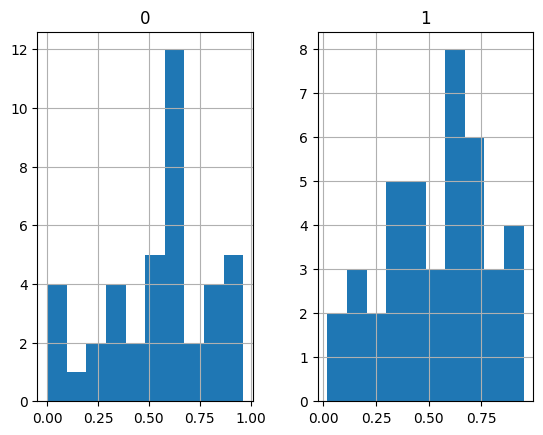

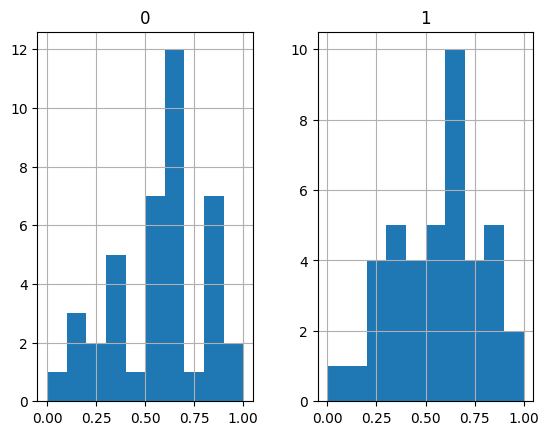

In [27]:
f1_inp_normal = pd.DataFrame(f1_inp_warped)
print("------------Original input distribution-----------------")
pd_inp.hist()

print("------------Transformed input distribution-----------------")
f1_inp_normal.hist()


# ***************************** Gaussian Process****************************


# ********************************************************************************

In [30]:
x_final = f1_inp_warped.copy()
y_final = f1_out_transformed.copy() # y_normalized (this was the first tranformed output I tired)


# Conclusion about the Kernel
- Adding noise gets a better LML 
- Making the outlier smaller imporves the LML, currently divided by 1.8


In [21]:
output_variants["Box-Cox-4"]

array([0.00260078, 0.00260078, 0.00260078, 0.00260078, 0.        ,
       0.00260078, 0.00260078, 0.00260078, 0.00260078, 0.00260078,
       0.00260078, 0.00260078, 0.00260078, 0.00260078, 0.00260078,
       0.00260078, 0.00260075, 0.00260078, 0.00522077, 0.00260078,
       0.00260078, 0.00260078, 0.00260078, 0.00260078, 0.00260078,
       0.00260078, 0.00260078, 0.00260078, 0.00263507, 0.0026031 ,
       0.00260078, 0.00260078, 0.00260078, 0.00260078, 0.00260078,
       0.00260078, 0.00196878])

###### Below I tried diffrent approach. Instead of training seperately a kernel, the process of training the kernel, and creating the gasussian process will be simultaneously. 
- The above aproach will be implemente din q5 because it is giving me a better lml(-1) compared to -19 on traning kernel seperately. 
- I will investigate if the iterated training has something to do with it, as we do not want the kernel to over fit. 

### Key Parameters for Exploration ↔ Exploitation
#### kappa (UCB): Typical range ~ 1 to 5.

- Larger → more exploration (search broader).
- Smaller → more exploitation (stick to known good regions).
#### xi (EI): Typical range ~ 0.0 to 0.1.

- Larger → more exploration (prefers trying uncertain areas).
- Smaller → more exploitation (focus on improving known good spots).
#### beta (Some libraries): Similar to kappa, often 1–5.

- Controls variance impact; higher → explorative.


- When the HEBOOptimizer is initialized, it first stores the raw X and y data. Since the Gaussian Process works best when the target variable is Gaussian, y_raw undergoes a Yeo-Johnson transformation using _apply_yeo_johnson(), which finds an optimal λ and transforms y_raw into y_transformed. This transformation ensures that the target variable is more Gaussian-like before training. After obtaining y_transformed, the _fit_gp() function is called to train a Gaussian Process model.

- Within _fit_gp(), X and y_transformed are converted to tensors (train_x and train_y). If a GP model (self.gp) already exists, it is reused to prevent redundant training. Otherwise, a new instance of CustomKernelGPModel is created, incorporating both the kernel and transformation. This model applies the Yeo-Johnson transformation dynamically inside its forward pass while also using a combination of Matern and RBF kernels.

- Once the GP model is instantiated, it enters training mode along with the likelihood function. The optimizer, Adam, is defined to update both the kernel and transformation parameters simultaneously by maximizing the Log Marginal Likelihood (LML). The training loop iterates, computing the negative LML (loss) and updating parameters. At each step, the transformation (λ) and kernel parameters are adjusted together to improve LML. The loop stops early if LML converges.

- Throughout training, the CustomKernelGPModel executes its forward pass, transforming train_y using Yeo-Johnson and passing it through the GP kernel to compute a posterior distribution. This ensures that λ is being optimized alongside the kernel hyperparameters, meaning the transformation and GP model evolve together.

- Once training is complete, the trained model is stored, and it is ready to be used for predictions. Since CustomKernelGPModel maintains the optimized transformation and kernel inside its structure, any future prediction will automatically apply the best transformation learned during training.

In [26]:
y_transformed_final = np.arcsinh(f1_out / 1.0)  # Using scale = 1.0
y_final = f1_out_transformed
x_final = f1_inp


In [50]:
x_final = f1_inp_warped.copy()
y_final = f1_out_transformed.copy() # y_normalized (this was the first tranformed output I tired)


In [3]:
x_final = f1_inp 
y_final = f1_out

In [70]:
import numpy as np

# Find the index of the maximum value in y_final
max_index = np.argmax(f1_out)

# Get the max value
max_value = f1_out[max_index]

# Get the corresponding row in x_final
corresponding_x = x_final[max_index]

# Display results
print("Max of y_final:", max_value)
print("Index of max:", max_index)
print("Corresponding x_final row:", corresponding_x)


Max of y_final: 1.4113100297315333
Index of max: 38
Corresponding x_final row: [0.624484 0.639821]


<Axes: >

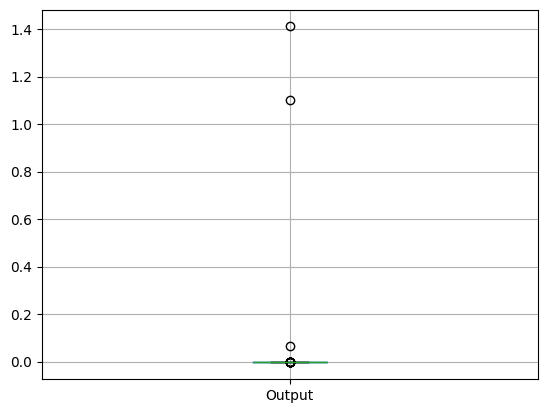

In [21]:
f1_out_transformed_test =  np.log1p(f1_out) 
f1_out_transformed_test

test_pd = pd.DataFrame(f1_out_transformed_test)
pd_out.boxplot()





In [61]:
x_final = f1_inp_warped.copy()

In [4]:
x_final = f1_inp
y_final = f1_out

In [5]:
import numpy as np

# Get indices of top 3 outputs (higher = better)
top_indices = np.argsort(y_final)[-4:][::-1]

# Get the top 3 output values
top_outputs = y_final[top_indices]

# Get corresponding inputs
top_inputs = x_final[top_indices]
top_indices,top_inputs

#1st should be higher than 0.624 but lower than 0.637
#2nd should be higher t

#0.627484,0.639921
# FINAL SUBMISON 

(array([38, 41, 40, 39]),
 array([[0.624484, 0.639821],
        [0.622   , 0.639486],
        [0.621091, 0.641312],
        [0.637917, 0.641067]]))

In [ ]:
# x1 bounds (Feature 1)
bound_x1 = (0.621091 - 0.001, 0.624484 + 0.001)  # (0.620091, 0.625484)
0.62099914 0.63952225
# x2 bounds (Feature 2), centered near 0.639821
bound_x2 = (0.639821 - 0.0015, 0.639821 + 0.0015)  # (0.638321, 0.641321)
6

In [65]:
from sklearn.gaussian_process import GaussianProcessRegressor

noise_level = max(0.01 * np.var(x_final), 1e-8)

test_kernel = C(1.0) * (
    Matern([0.01, 0.10], nu=1.5) +   # models moderate non-linearity with short length scales
    RBF([0.01, 0.10], length_scale_bounds=(1e-2, 5))  # models smooth trends, constrained
) + WhiteKernel(noise_level, noise_level_bounds=(1e-18, 0.1))  # handles noise



gp = GaussianProcessRegressor(kernel=test_kernel, normalize_y=False)
gp.fit(x_final, y_final)
print("Log Marginal Likelihood (LML):", gp.log_marginal_likelihood_value_)



Log Marginal Likelihood (LML): 30.95255009127402


Next point to evaluate: [0.62855631 0.63907646]
Mean Squared Error (MSE): 8.722471690507366e-12
------------------------------------------------------------------------------------------------------------
Next Best Point (MACE): 1.47999307e+00 at (x1=0.628556, x2=0.639076
------------------------------Visualisation------------------------------------


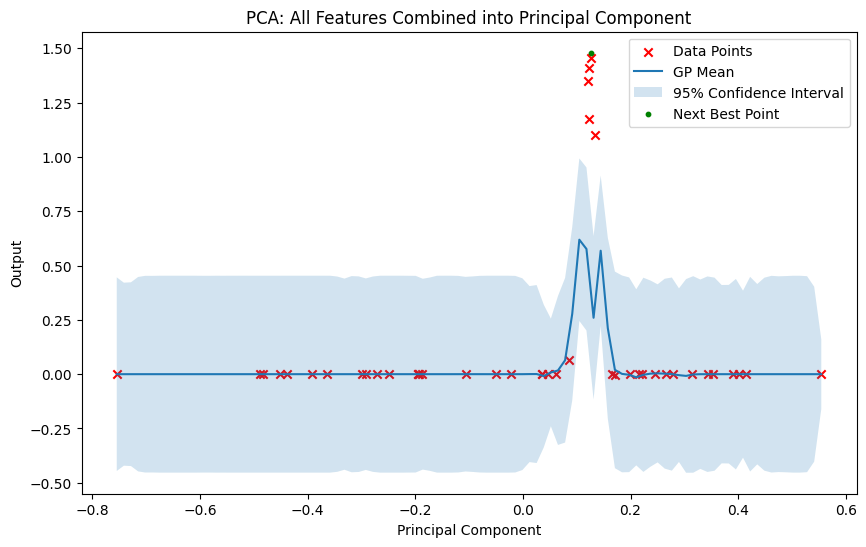

Next best point (4D): [0.62855631 0.63907646]
Predicted value at next best point: 1.479993


In [4]:

import numpy as np
from scipy.stats import norm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from scipy.interpolate import griddata
from pymoo.core.problem import Problem
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import( ConstantKernel as C, RationalQuadratic,RBF, WhiteKernel)

class HEBOOptimizer:
    def __init__(self, bounds, initial_X=None, initial_y=None,
                 beta=2.5, xi=1.0, epsilon=0.1, random_state=None, noise_factor=0.01):

        self.bounds = np.array(bounds)
        self.dim = len(bounds)
        self.beta = beta
        self.xi = xi
        self.epsilon = epsilon
        self.rng = np.random.RandomState(random_state)
        
        # Initialize data storage
        self.X = initial_X 
        self.y = initial_y 
        noise_level = max(noise_factor * np.var(x_final), 1e-8)
        # Configure GP kernel
        self.kernel = C(1.0) * (
            Matern([0.01, 0.10], nu=1.5) +   # models moderate non-linearity with short length scales
            RBF([0.01, 0.10], length_scale_bounds=(1e-2, 5))  # models smooth trends, constrained
        ) + WhiteKernel(noise_level, noise_level_bounds=(1e-18, 0.1))  # handles noise


    def _fit_gp(self, kernel=None):
        if kernel is None:
            kernel = self.kernel
        gp = GaussianProcessRegressor(
            kernel=kernel,
            normalize_y=False,
            alpha=1e-6,            # Increase alpha for numerical stability
            random_state=self.rng
        )
        gp.fit(self.X, self.y)
        return gp




    def _stochastic_mean(self, mu, noise_var):
        """HEBO's noise-adjusted mean"""
        return mu + self.xi * noise_var

    def _mace_optimization(self, gp):
        """Core MACE multi-acquisition optimization"""
        class MACEProblem(Problem):
            def __init__(self, gp, bounds, best, beta, xi):
                super().__init__(n_var=len(bounds), n_obj=3,
                                xl=[b[0] for b in bounds], xu=[b[1] for b in bounds])
                self.gp = gp
                self.best = best
                self.beta = beta
                self.xi = xi

            def _evaluate(self, X, out, *args, **kwargs):
                mu, sigma = self.gp.predict(X, return_std=True)
                
                # Correct way to access noise level
                noise_var = self.gp.kernel_.get_params().get('k2__noise_level', 1e-9)
                
                mu_adj = mu + self.xi * noise_var  # HEBO's stochastic mean
                
                # Calculate acquisition functions
                sigma = np.maximum(sigma, 1e-9)  # Avoid divide by zero
                Z = (mu_adj - self.best) / sigma
                
                ei = (mu_adj - self.best) * norm.cdf(Z) + sigma * norm.pdf(Z)
                pi = norm.cdf(Z)
                ucb = mu_adj + self.beta * sigma
                
                # Minimize [-EI, -PI, UCB]
                out["F"] = np.column_stack([-ei, -pi, ucb])

        if len(self.y) == 0:
            return self._random_sample()
        
        problem = MACEProblem(gp, self.bounds, np.max(self.y), self.beta, self.xi)
        algorithm = NSGA2(pop_size=50, eliminate_duplicates=True)
        res = minimize(problem,
               algorithm,
               termination=('n_gen', 100),
               seed=1,
               verbose=False)

        
        if res.X.size == 0:
            return self._random_sample()
        
        # Select best candidate from Pareto front (maximize EI)
        return res.X[np.argmax(-res.F[:, 0])]

    def _random_sample(self):
        """Generate random sample within bounds"""
        return np.array([self.rng.uniform(low, high) for (low, high) in self.bounds]).reshape(1, -1)

    def suggest_next_point(self):
        """Returns next candidate point for evaluation (maximization)"""
        # Epsilon-greedy exploration
        if self.rng.rand() < self.epsilon:
            return self._random_sample()
        # Fit GP with current data
        gp = self._fit_gp()
        # Run MACE optimization
        candidate = self._mace_optimization(gp)
        
        # Ensure candidate is within bounds
        return np.clip(candidate, self.bounds[:, 0], self.bounds[:, 1])

    def update_data(self, X_new, y_new):
        """Update observed data with new point(s)"""
        self.X = np.vstack([self.X, np.atleast_2d(X_new)])
        self.y = np.concatenate([self.y, np.atleast_1d(y_new)])
    

## Change this depending if the input is normalised/tranformed or not
# def get_dynamic_bounds(x_final):
#     return [(0, 1) if np.all((x >= 0) & (x <= 1)) else (x.min(), x.max()) for x in x_final.T]

# bounds = get_dynamic_bounds(x_final)
# import numpy as np



x_best = np.array([0.61223927, 0.62727571])
x_best1 = np.array([0.63542483 , 0.64941594])
x_best2 = np.array([0.624484, 0.639821])
percent_range = 0.02  # 2% range

# Compute bounds
# x1 bounds (Feature 1)
bound_x1 = [0.622, 0.624484 + 0.001]  # (0.620091, 0.625484)

# x2 bounds (Feature 2), centered near 0.639821
bound_x2 = [0.639821 - 0.0015, 0.639821 + 0.0015]  # (0.638321, 0.641321)



import numpy as np

def get_bayesian_bounds(x_final):
    """
    Given a 2D array x_final (N rows, d features),
    returns a list of (min, max) tuples for each feature 
    to serve as bounds in Bayesian optimization.
    """
    min_vals = np.min(x_final, axis=0)
    max_vals = np.max(x_final, axis=0)
    return [(low, high) for low, high in zip(min_vals, max_vals)]
bounds = get_bayesian_bounds(x_final)

hebo = HEBOOptimizer(
    bounds=bounds,
    initial_X=x_final,
    initial_y=y_final,
    # Controls exploration in UCB: Higher β explores more, Lower β exploits more
    beta = 1.2,  # Expands search boundaries by considering high-uncertainty areas

    # Adjusts the stochastic mean: Higher ξ favors noisier, uncertain regions
    xi = 0.2, # Increases exploration in noisy areas, expanding search range

    # Exploration probability: Higher ε increases random sampling
    epsilon = 0.1 # Ad
)

# 3. Get next candidate point
next_point = hebo.suggest_next_point().flatten()
#next_point = hebo.suggest_next_point().reshape(-1)

# next z is predicited value at the inputs found from nextpoint, we use gausian
# process that we had trained above 
next_z = hebo._fit_gp().predict(next_point.reshape(1, -1))[0]
print(f"Next point to evaluate: {next_point}")
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.2, random_state=42)

gp = hebo._fit_gp()
y_pred, y_std = gp.predict(X_test, return_std=True)

# Compute Mean Squared Error
mse = np.mean((y_pred - y_test) ** 2)



# Print information about the points
#print(f"Maximum Value: {max_z:.8e} at (x1={max_x:.4f}, x2={max_y:.6f}) at output, {np.max(y_final)}")
#print(f"Minimum Value: {min_z:.8e} at (x1={min_x:.4f}, x2={min_y:.6f})")
#print(f"Last Added Point: {last_z:.8e} at (x1={last_x:.6f}, x2={last_y:.6f})")
print(f"Mean Squared Error (MSE): {mse}")
print("------------------------------------------------------------------------------------------------------------")
print(f"Next Best Point (MACE): {next_z:.8e} at (x1={next_point[0]:.6f}, x2={next_point[1]:.6f}")

print("------------------------------Visualisation------------------------------------")


# test_kernel = (
#             C(1.0, (1e-14, 1e3)) *  # ConstantKernel (scale)
#             (
#                 RBF(length_scale=2,  # Large length scale for feature 2 (ignored)
#                     length_scale_bounds=[(3.43e-7, 1.0)])
#                 +
#                 ExpSineSquared(length_scale=0.5, periodicity=2,  # Single length scale for all
#                                length_scale_bounds=(3.43e-3, 4.0),
#                                periodicity_bounds=(1e-2, 1e1))
#             )
#             + WhiteKernel(noise_level=0.02, noise_level_bounds=(1e-6, 0.5))  # Noise
#         )




# # # Fit GP model
# hebo.kernel = test_kernel  # e.g., RBF(...) + WhiteKernel(...)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce to 1D
pca = PCA(n_components=1)
t_data = pca.fit_transform(x_final).ravel()
t_next = pca.transform(next_point.reshape(1, -1)).item()

# Create a grid along the PCA component
t_values = np.linspace(t_data.min(), t_data.max(), 100)
X_plot = pca.inverse_transform(t_values.reshape(-1, 1))

gp = hebo._fit_gp()

# Get next best point from HEBO
next_point = hebo.suggest_next_point().flatten()
# GP predictions along the grid
mean_pred, std_pred = gp.predict(X_plot, return_std=True)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(t_data, y_final, color='red', marker='x', label='Data Points')
plt.plot(t_values, mean_pred, label='GP Mean')
plt.fill_between(t_values, mean_pred - 1.96 * std_pred, mean_pred + 1.96 * std_pred, alpha=0.2, label='95% Confidence Interval')
plt.scatter(t_next, gp.predict(next_point.reshape(1, -1))[0], color='green', s=10, marker='o', label='Next Best Point')
plt.title('PCA: All Features Combined into Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Output')
plt.legend()
plt.show()

print("Next best point (4D):", next_point)
print(f"Predicted value at next best point: {gp.predict(next_point.reshape(1, -1))[0]:.6f}")


In [2]:
# !pip install pymoo

In [ ]:
print("------------------------------Visualisation------------------------------------")


# test_kernel = (
#             C(1.0, (1e-14, 1e3)) *  # ConstantKernel (scale)
#             (
#                 RBF(length_scale=2,  # Large length scale for feature 2 (ignored)
#                     length_scale_bounds=[(3.43e-7, 1.0)])
#                 +
#                 ExpSineSquared(length_scale=0.5, periodicity=2,  # Single length scale for all
#                                length_scale_bounds=(3.43e-3, 4.0),
#                                periodicity_bounds=(1e-2, 1e1))
#             )
#             + WhiteKernel(noise_level=0.02, noise_level_bounds=(1e-6, 0.5))  # Noise
#         )




# # # Fit GP model
# hebo.kernel = test_kernel  # e.g., RBF(...) + WhiteKernel(...)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce to 1D
pca = PCA(n_components=1)
t_data = pca.fit_transform(x_final).ravel()
t_next = pca.transform(next_point.reshape(1, -1)).item()

# Create a grid along the PCA component
t_values = np.linspace(t_data.min(), t_data.max(), 100)
X_plot = pca.inverse_transform(t_values.reshape(-1, 1))

gp = hebo._fit_gp()

# Get next best point from HEBO
next_point = hebo.suggest_next_point().flatten()
# GP predictions along the grid
mean_pred, std_pred = gp.predict(X_plot, return_std=True)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(t_data, y_final, color='red', marker='x', label='Data Points')
plt.plot(t_values, mean_pred, label='GP Mean')
plt.fill_between(t_values, mean_pred - 1.96 * std_pred, mean_pred + 1.96 * std_pred, alpha=0.2, label='95% Confidence Interval')
plt.scatter(t_next, gp.predict(next_point.reshape(1, -1))[0], color='green', s=100, marker='o', label='Next Best Point')
plt.title('PCA: All Features Combined into Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Output')
plt.legend()
plt.show()

print("Next best point (4D):", next_point)
print(f"Predicted value at next best point: {gp.predict(next_point.reshape(1, -1))[0]:.6f}")


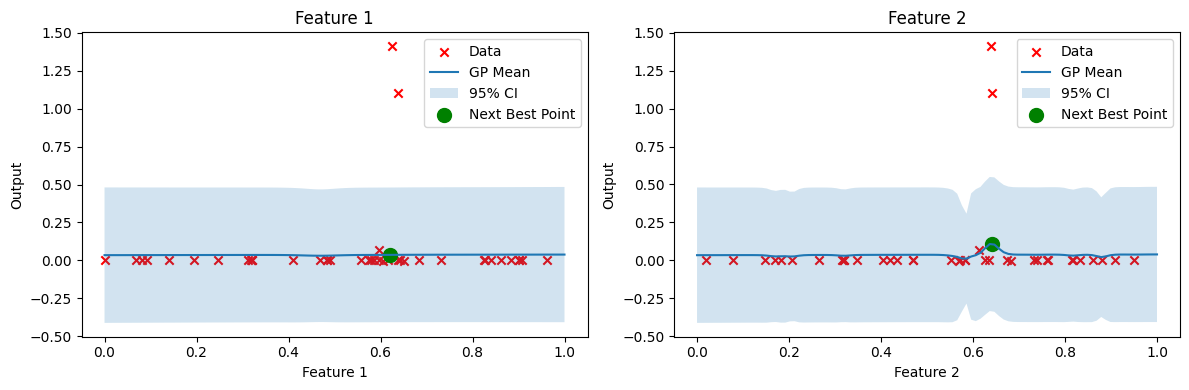

Next best point (nD): [0.62153771 0.64054851]
Predicted mean at next best point: 1.3916
Predicted std at next best point: 0.0404


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Number of features
n_features = x_final.shape[1]

# Calculate feature means and set up grid
means_other_features = np.mean(x_final, axis=0)
grid = np.linspace(0, 1, 100)

# Predict at the next best point
next_mean, next_std = gp.predict(next_point.reshape(1, -1), return_std=True)

# Determine the subplot arrangement (rows x cols)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()  # Flatten to easily iterate

for i in range(n_features):
    ax = axes[i]

    # Prepare grid points for this feature
    X_plot = np.tile(means_other_features, (100, 1))
    X_plot[:, i] = grid
    mean_pred, std_pred = gp.predict(X_plot, return_std=True)

    # Plot data, GP mean, and confidence interval
    ax.scatter(x_final[:, i], y_final, color='r', marker='x', label='Data')
    ax.plot(grid, mean_pred, label='GP Mean')
    ax.fill_between(grid, mean_pred - 1.96 * std_pred, mean_pred + 1.96 * std_pred,
                    alpha=0.2, label='95% CI')
    
    # Highlight next best point
    X_next = means_other_features.copy()
    X_next[i] = next_point[i]
    y_next_dim = gp.predict(X_next.reshape(1, -1))[0]
    ax.scatter(next_point[i], y_next_dim, color='green', s=100, marker='o', label='Next Best Point')

    ax.set_title(f'Feature {i+1}')
    ax.set_xlabel(f'Feature {i+1}')
    ax.set_ylabel('Output')
    ax.legend()

# Hide any unused subplots if n_features isn't a multiple of 2
for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("Next best point (nD):", next_point)
print(f"Predicted mean at next best point: {next_mean[0]:.4f}")
print(f"Predicted std at next best point: {next_std[0]:.4f}")


In [3]:
# ignore folders
!echo Queries/ >> .gitignore
!echo .ipynb_checkpoints/ >> .gitignore

# un-track anything already committed
!git rm -r --cached Queries/ .ipynb_checkpoints/

# add the updated ignore file
!git add .gitignore

# stage your finished work (adjust paths)
!git add f*_optimisation.ipynb f*_result/ final_project/*

# commit & push
!git commit -m "Add final project + results; ignore Queries and .ipynb_checkpoints"
!git push


rm 'initial_data/0.0 notebooks/.ipynb_checkpoints/f1_optimisation-checkpoint.ipynb'
rm 'initial_data/0.0 notebooks/.ipynb_checkpoints/f2_optimisation - Copy-checkpoint.ipynb'
rm 'initial_data/0.0 notebooks/.ipynb_checkpoints/f2_optimisation-checkpoint.ipynb'
rm 'initial_data/0.0 notebooks/.ipynb_checkpoints/f3_optimisation - Copy-checkpoint.ipynb'
rm 'initial_data/0.0 notebooks/.ipynb_checkpoints/f3_optimisation-checkpoint.ipynb'
rm 'initial_data/0.0 notebooks/.ipynb_checkpoints/f4_optimisation-checkpoint.ipynb'
rm 'initial_data/0.0 notebooks/.ipynb_checkpoints/f5_optimisation - Copy-checkpoint.ipynb'
rm 'initial_data/0.0 notebooks/.ipynb_checkpoints/f5_optimisation-checkpoint.ipynb'
rm 'initial_data/0.0 notebooks/.ipynb_checkpoints/f6_optimisation - Copy-checkpoint.ipynb'
rm 'initial_data/0.0 notebooks/.ipynb_checkpoints/f6_optimisation-checkpoint.ipynb'
rm 'initial_data/0.0 notebooks/.ipynb_checkpoints/f7_optimisation - Copy-checkpoint.ipynb'
rm 'initial_data/0.0 notebooks/.ipynb_che

fatal: pathspec 'f*_result/' did not match any files


[master 4b78875] Add final project + results; ignore Queries and .ipynb_checkpoints
 30 files changed, 2 insertions(+), 55074 deletions(-)
 create mode 100644 initial_data/0.0 notebooks/.gitignore
 delete mode 100644 initial_data/0.0 notebooks/.ipynb_checkpoints/f1_optimisation-checkpoint.ipynb
 delete mode 100644 initial_data/0.0 notebooks/.ipynb_checkpoints/f2_optimisation - Copy-checkpoint.ipynb
 delete mode 100644 initial_data/0.0 notebooks/.ipynb_checkpoints/f2_optimisation-checkpoint.ipynb
 delete mode 100644 initial_data/0.0 notebooks/.ipynb_checkpoints/f3_optimisation - Copy-checkpoint.ipynb
 delete mode 100644 initial_data/0.0 notebooks/.ipynb_checkpoints/f3_optimisation-checkpoint.ipynb
 delete mode 100644 initial_data/0.0 notebooks/.ipynb_checkpoints/f4_optimisation-checkpoint.ipynb
 delete mode 100644 initial_data/0.0 notebooks/.ipynb_checkpoints/f5_optimisation - Copy-checkpoint.ipynb
 delete mode 100644 initial_data/0.0 notebooks/.ipynb_checkpoints/f5_optimisation-checkpo

remote: This repository moved. Please use the new location:        
remote:   https://github.com/Alerdo/BlackBox-Bayesian_Optimisation.git        
To https://github.com/Alerdo/IMP-PCMLAI-capstone-initial_data.git
   e6f77d4..4b78875  master -> master


In [8]:


# verify
!git remote -v



origin	https://github.com/Alerdo/BlackBox-Bayesian_Optimisation.git (fetch)
origin	https://github.com/Alerdo/BlackBox-Bayesian_Optimisation.git (push)


🔥 The acquisition function operates in warped space, but since the objective function expects original inputs, we must inverse-transform before querying, while ensuring the GP is updated with transformed outputs for correct Bayesian Optimization! 🔥

In [40]:
import numpy as np

def kumaraswamy_inverse_warp(Y, a, b):
    Y = np.asarray(Y)  # Ensure Y is a NumPy array
    return (1 - (1 - Y) ** (1/b)) ** (1/a)

# Input values
Y_values = np.array([0.61398724, 0.99999992])
Y_values1 = np.array([0.58046688, 0.57276951])
 
next_point_original = kumaraswamy_inverse_warp(Y_values1, a=0.237299, b=0.309265)

# Format the output correctly
formatted_output = f"{next_point_original[0]:.6f}, {next_point_original[1]:.6f}"
print("Next Point (Original Scale):", formatted_output)


Next Point (Original Scale): 0.769483, 0.756965


In [1]:
!git status

On branch master
Your branch is ahead of 'origin/master' by 4 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .ipynb_checkpoints/f1_optimisation-checkpoint.ipynb
	modified:   .ipynb_checkpoints/f2_optimisation-checkpoint.ipynb
	modified:   .ipynb_checkpoints/f3_optimisation-checkpoint.ipynb
	modified:   .ipynb_checkpoints/f4_optimisation-checkpoint.ipynb
	modified:   .ipynb_checkpoints/f5_optimisation-checkpoint.ipynb
	modified:   .ipynb_checkpoints/f6_optimisation-checkpoint.ipynb
	deleted:    .ipynb_checkpoints/f8_optimisation - Copy-checkpoint.ipynb
	deleted:    .ipynb_checkpoints/test_model-checkpoint.py
	deleted:    Notes/.ipynb_checkpoints/scaling_small_data_script-checkpoint.ipynb
	deleted:    Notes/First_Submition.txt
	deleted:    Notes/function 8 inital version/f8_optimisation - Copy.ipynb